pip install protobuf==3.20

In [10]:
import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()
train_ds, validation_ds, test_ds = tfds.load(
    "cats_vs_dogs",
    # 0~10% 구간 train, 10~20% 구간 val, 20~30% 구간 test
    split=["train[:10%]", "train[10%:20%]", "train[20%:30%]"],
    as_supervised=True,  # lable 포함(지도학습)
)

tf.data.experimental.cardinality(train_ds), tf.data.experimental.cardinality(validation_ds), tf.data.experimental.cardinality(test_ds)

(<tf.Tensor: shape=(), dtype=int64, numpy=2326>,
 <tf.Tensor: shape=(), dtype=int64, numpy=2326>,
 <tf.Tensor: shape=(), dtype=int64, numpy=2327>)

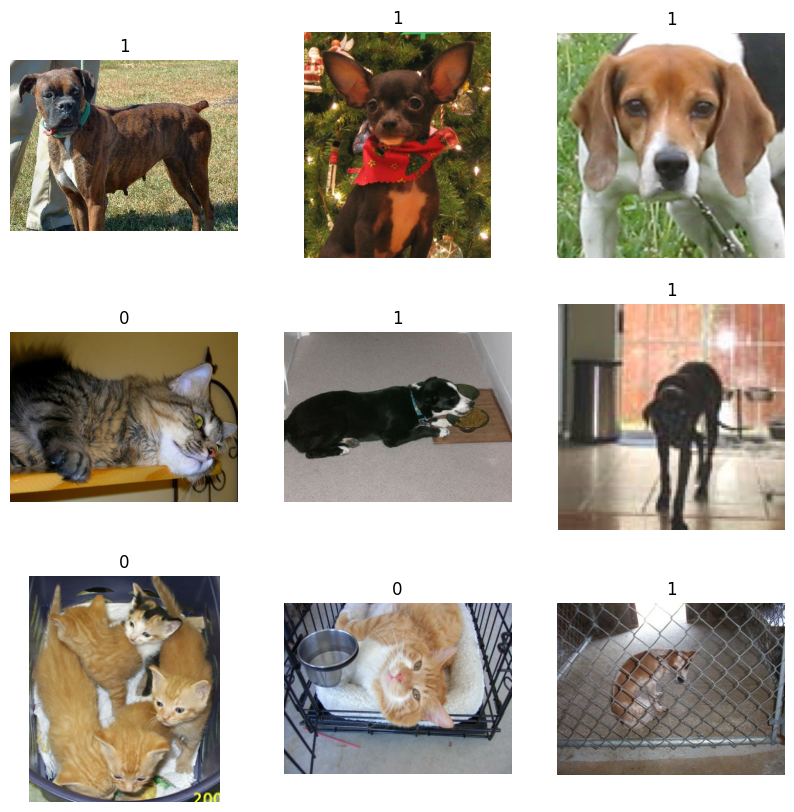

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(int(label))
    plt.axis("off")

In [12]:
size = (150, 150)
train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, size), y))
validation_ds = validation_ds.map(lambda x, y: (tf.image.resize(x, size), y))
test_ds = test_ds.map(lambda x, y: (tf.image.resize(x, size), y))

In [13]:
batch_size = 1     # local에서 돌리기 위해서 배치사이즈를 작게 함. 빠르게 하려면 더 높여야 함
train_ds = train_ds.take(600).batch(batch_size)
validation_ds = validation_ds.take(200).batch(batch_size)
test_ds = test_ds.take(200).batch(batch_size)

In [14]:
from tensorflow import keras
from tensorflow.keras.layers import RandomFlip, RandomRotation, Dense
from tensorflow.keras import Sequential, Input
data_augmentation = Sequential(
    [RandomFlip("horizontal"), RandomRotation(0.1),]
)

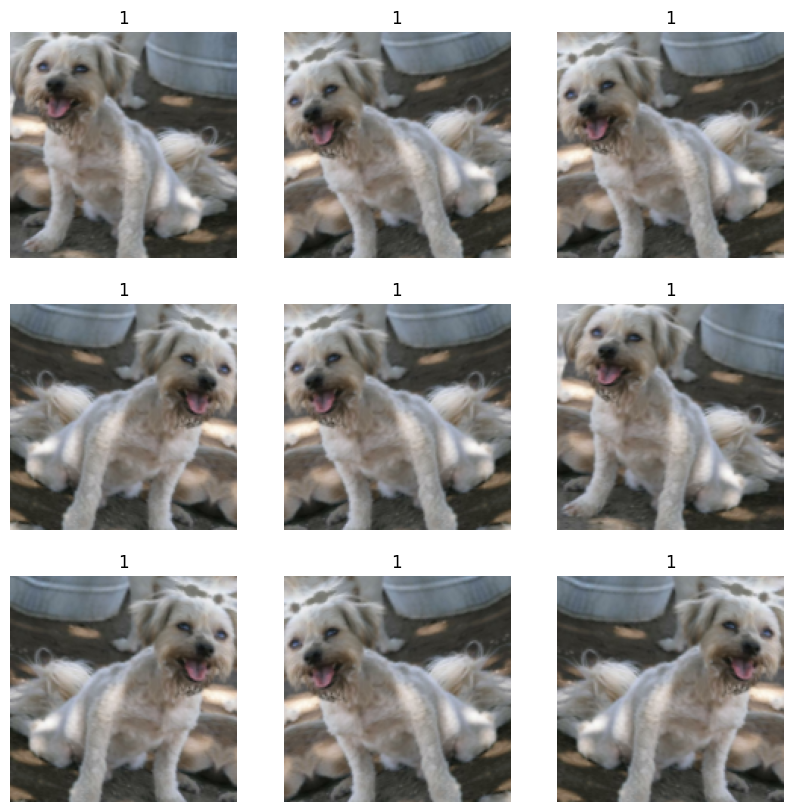

In [15]:
# 이미지 증강

import numpy as np
tf.get_logger().setLevel('ERROR')
for images, labels in train_ds.skip(100).take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.title(int(labels[0]))
        plt.axis("off")

In [17]:
base_model = tf.keras.applications.vgg19.VGG19(
    weights = 'imagenet',        # load weights pre-trained on ImageNet, 대량의 이미지 데이터셋
    input_shape = (150,150,3),
    include_top=False,   # output layer 제거, output은 새로운 모델ㄹ로 붙이려고 함
)

base_model.trainable = False   # 레이어동결

inputs = keras.Input(shape = (150, 150, 3))
x = data_augmentation(inputs)

scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(x)
x = base_model(x, training=False)    # 사전훈련모델
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)
outputs = keras.layers.Dense(1)(x)
model1 = keras.Model(inputs, outputs)
model1.compile(
    optimizer=keras.optimizers.Adam(1e-5),   # low learning rate
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics = [keras.metrics.BinaryAccuracy()],
)
model1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 150, 150, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 150, 150, 3)       0         
                                                                 
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                             

In [18]:
epochs=2
model1.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Epoch 1/2
600/600 [==============================] - 27s 36ms/step - loss: 0.7306 - binary_accuracy: 0.5383 - val_loss: 0.7385 - val_binary_accuracy: 0.5150
Epoch 2/2
600/600 [==============================] - 22s 36ms/step - loss: 0.7274 - binary_accuracy: 0.5417 - val_loss: 0.7290 - val_binary_accuracy: 0.5150


In [19]:
# fine tuning
base_model.trainable = True  # layer동결 해제    False 추론모드 / True 학습모드
model2 = keras.Model(inputs, outputs)
model2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 150, 150, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 150, 150, 3)       0         
                                                                 
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                           

In [20]:
model2.compile(
    optimizer=keras.optimizers.Adam(1e-5),   # low learning rate
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

In [21]:
epochs=2
model2.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Epoch 1/2
600/600 [==============================] - 62s 95ms/step - loss: 0.5276 - binary_accuracy: 0.7050 - val_loss: 0.2275 - val_binary_accuracy: 0.8950
Epoch 2/2
600/600 [==============================] - 56s 94ms/step - loss: 0.2781 - binary_accuracy: 0.8817 - val_loss: 0.2075 - val_binary_accuracy: 0.9300
